In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import emoji
import re
import wget
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, LSTM, Input, Dropout, Activation, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau
import tensorflow_hub as hub

##### Plot Defaults

In [71]:
sns.set(font='sans-serif',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":18})

##### Loading GoEmotion Data

In [67]:
file1 = pd.read_csv('./GoEmotion/goemotions_1.csv')
file2 = pd.read_csv('./GoEmotion/goemotions_2.csv')
file3 = pd.read_csv('./GoEmotion/goemotions_3.csv')
df = pd.concat([file1, file2, file3], ignore_index=True)
df = df[df['example_very_unclear'] == False].reset_index(drop=True)
df = df.drop_duplicates(subset=['text'])
df.head(5)

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
2,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
3,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1
4,Right? Considering it’s such an important docu...,eespn2i,ImperialBoss,TrueReddit,t3_aizyuz,t1_eesoak0,1.548280e+09,61,False,0,...,0,0,0,0,0,0,0,0,0,0


##### Exploratory Data Analysis

In [79]:
labels = df.iloc[:, 9:]
labels.head(5)

,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
labels_summary = df.iloc[:, 9:].sum()

In [68]:
labels_summary.sort_values(ascending=False, inplace=True)

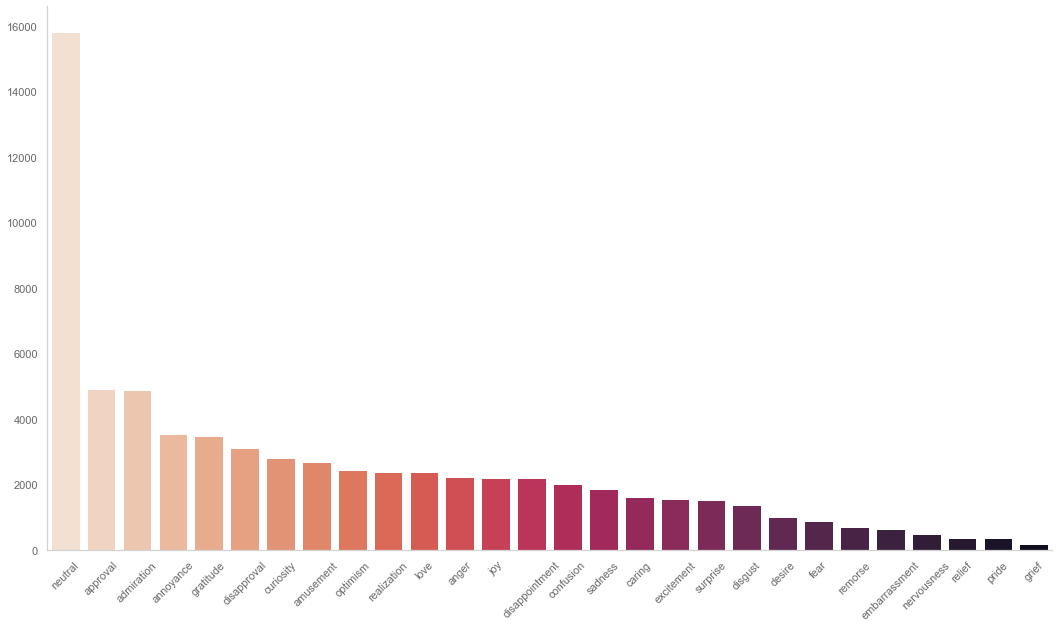

In [70]:
fig = plt.figure(figsize=(18, 10))
sns.barplot(x=labels_summary.index, y=labels_summary.values, palette='rocket_r')
plt.xticks(rotation=45)
plt.show()


In [73]:
nltk.download('stopwords')
new_words = ['NAME']
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(new_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vinee\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


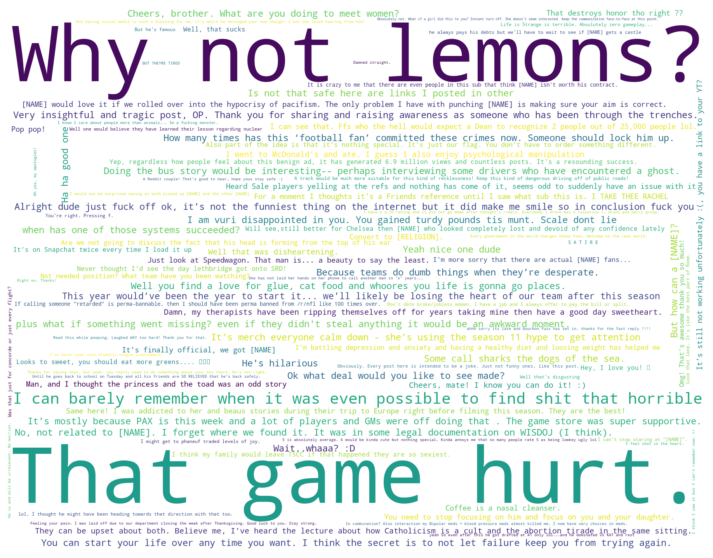

In [78]:
from wordcloud import WordCloud

worldcloud = WordCloud(stopwords=stopwords, background_color='white', width=1800, height=1400, max_words=100, random_state=42).generate_from_frequencies(df['text'].value_counts())

fig = plt.figure(figsize=(18, 10))
plt.imshow(worldcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [102]:
def clean_text(text):
    """
    This function cleans the text in the dataframe and returns a list of cleaned text.
    text: a string
    
    return: modified initial string
    """
    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:', '', text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(r'\s+', ' ', text)

    return text

In [139]:
X = []
rows = list(df['text'])
for text in rows:
    X.append(clean_text(text))

In [163]:
Y = df.iloc[:, 9:].values

##### Test/Train split

In [164]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

##### Tokenizer